In [3]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os
from keras.utils.np_utils import to_categorical

In [7]:
emotion_data = pd.read_csv('fer2013.csv')
print("Training Dataset")
print(emotion_data[emotion_data['Usage']=='Training'].head(5))
print("Test Dataset")
print(emotion_data[emotion_data['Usage']=='PublicTest'].head(5))

Training Dataset
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Test Dataset
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [12]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
#function to show the images of faces of a person and the associated emotion
training_data=emotion_data[emotion_data['Usage']=='Training']
def fer2013_show_instance(index):
    """Shows the image and the emotion label of the index's instance."""
    image = np.reshape(training_data.at[index, "pixels"].split(" "), (48,48)).astype("float")
    image = cv2.resize(image, (200, 200)) # Reshaping images to preferred size
    image -= np.mean(image)
    image /= np.std(image)
    #print(emotion_labels[training_data.at[index, "emotion"]])
    plt.imshow(image, cmap="gray")
    

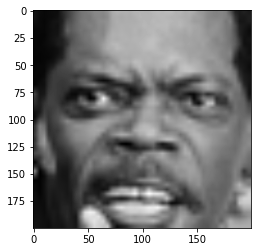

In [13]:
fer2013_show_instance(10)

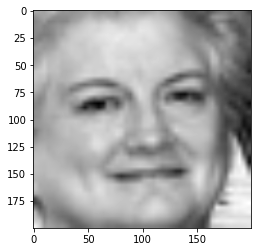

In [14]:
fer2013_show_instance(100)

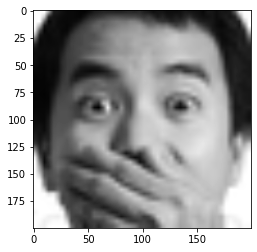

In [15]:
fer2013_show_instance(480)

# Part 2 Using a Pretrained VGG-16 And ResNet Model

In [16]:
data = pd.read_csv('fer2013.csv')
height,width,depth = 48,48,1
#taken emotion labels in order
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [17]:
#function to get training and test data to prepare a model
def convert_fer2013(data):
    pixels = data['pixels'].tolist()
    faces = []
    for pixel_sq in pixels:
        face = [int(pixel) for pixel in pixel_sq.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), (width, height))
        face = np.stack((face,)*3, -1)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    emotions = pd.get_dummies(data['emotion'])

    return faces, emotions

X_train, y_train = convert_fer2013(data[data['Usage'] == 'Training'])
X_test, y_test = convert_fer2013(data[data['Usage'] == 'PublicTest'])

In [18]:
#standarization/normalization of pixels for better accuracy
def normalize(imgs):
    new_imgs = []
    for img in imgs:
        img = img / 255.0
        new_imgs.append(img)

    return new_imgs
X_train = np.array(normalize(X_train))
X_test = np.array(normalize(X_test))

In [19]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((28709, 48, 48, 3), (28709, 7), (3589, 48, 48, 3), (3589, 7))

In [20]:
def transfer_learning(model):
    for layer in model.layers:
        layer.trainable = False
#vgg model        
model_vgg = VGG16(include_top=False,
              weights='imagenet',
              pooling='avg')
#resnet model
model_resnet = ResNet50(include_top=False,
              weights='imagenet',
              pooling='avg')

models = [model_vgg,model_resnet]
model_name = ["VGG","RESNET"]

94773248/94765736 [==============================] - 1s 0us/step


In [21]:
from keras.models import Model
import time
#Model Training
def training_model(para):
    model = para;
    x = model.output

    y = Dense(num_classes,
            activation='softmax')(x)

    final_model = Model(inputs=model.input,
                                outputs=y)
        
    opt = SGD(lr=0.0005, momentum=0.9, nesterov=True)

    final_model.compile(optimizer=opt,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
    t1=time.time()
    final_model.fit(X_train, y_train,
                        batch_size=32,
                            epochs=10,
                            validation_split=0.1,
                            shuffle=True,
                            verbose=2)

    for layer in final_model.layers[4:]:
        layer.trainable = True

    final_model.compile(optimizer=opt,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
    t2=time.time()
    print('The time taken to train the model is',round(int(t2-t1)/60,2),'minutes')
    scores = final_model.evaluate(X_test, y_test,
                                  batch_size=32)

    print("Loss"+ str(scores[0]))
    print("Accuracy"+ str(scores[1]))
        
    return final_model 

In [22]:
print("training VGG")
vgg=training_model(model_vgg)

training VGG
Epoch 1/10
808/808 - 39s - loss: 1.3877 - accuracy: 0.4645 - val_loss: 1.2218 - val_accuracy: 0.5444
Epoch 2/10
808/808 - 32s - loss: 1.1470 - accuracy: 0.5633 - val_loss: 1.1528 - val_accuracy: 0.5559
Epoch 3/10
808/808 - 32s - loss: 1.0423 - accuracy: 0.6069 - val_loss: 1.0388 - val_accuracy: 0.5998
Epoch 4/10
808/808 - 32s - loss: 0.9569 - accuracy: 0.6380 - val_loss: 1.0498 - val_accuracy: 0.5928
Epoch 5/10
808/808 - 32s - loss: 0.8815 - accuracy: 0.6714 - val_loss: 0.9697 - val_accuracy: 0.6294
Epoch 6/10
808/808 - 32s - loss: 0.8017 - accuracy: 0.7026 - val_loss: 1.0875 - val_accuracy: 0.5956
Epoch 7/10
808/808 - 32s - loss: 0.7205 - accuracy: 0.7347 - val_loss: 1.0417 - val_accuracy: 0.6196
Epoch 8/10
808/808 - 32s - loss: 0.6316 - accuracy: 0.7719 - val_loss: 1.0586 - val_accuracy: 0.6290
Epoch 9/10
808/808 - 32s - loss: 0.5459 - accuracy: 0.8029 - val_loss: 1.1171 - val_accuracy: 0.6186
Epoch 10/10
808/808 - 32s - loss: 0.4524 - accuracy: 0.8400 - val_loss: 1.0834

In [ ]:
print("training Resnet")
resnet=training_model(model_resnet) 

training Resnet
Epoch 1/10
808/808 - 41s - loss: 1.6031 - accuracy: 0.4017 - val_loss: 1.7025 - val_accuracy: 0.3918
Epoch 2/10
808/808 - 36s - loss: 1.1347 - accuracy: 0.5756 - val_loss: 1.2533 - val_accuracy: 0.5326
Epoch 3/10
808/808 - 36s - loss: 0.8864 - accuracy: 0.6730 - val_loss: 1.1936 - val_accuracy: 0.5674
Epoch 4/10
808/808 - 36s - loss: 0.6738 - accuracy: 0.7601 - val_loss: 1.3312 - val_accuracy: 0.5576
Epoch 5/10
808/808 - 36s - loss: 0.4863 - accuracy: 0.8323 - val_loss: 1.3143 - val_accuracy: 0.5876
Epoch 6/10
808/808 - 36s - loss: 0.3442 - accuracy: 0.8837 - val_loss: 1.5000 - val_accuracy: 0.5740
Epoch 7/10
808/808 - 36s - loss: 0.2504 - accuracy: 0.9190 - val_loss: 1.6291 - val_accuracy: 0.5775
Epoch 8/10
808/808 - 36s - loss: 0.1915 - accuracy: 0.9373 - val_loss: 1.6343 - val_accuracy: 0.6012
Epoch 9/10
808/808 - 36s - loss: 0.1439 - accuracy: 0.9543 - val_loss: 1.7268 - val_accuracy: 0.5911
Epoch 10/10
808/808 - 36s - loss: 0.1193 - accuracy: 0.9632 - val_loss: 1.8

In [33]:
data[data['Usage'] == 'PublicTest'].head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [39]:
#getting pixel information for 28711/X_test[2]
pix=data[data['Usage'] == 'PublicTest']['pixels'][28711]
pix

'69 118 61 60 96 121 103 87 103 88 70 90 115 122 123 124 129 132 133 131 131 121 113 110 101 100 99 114 113 105 106 107 120 123 124 130 138 135 136 147 143 137 129 126 125 118 124 144 66 115 57 45 118 213 158 93 95 69 87 108 124 124 125 131 133 139 135 131 128 129 125 112 106 102 110 106 116 119 117 124 133 135 133 141 139 145 149 151 152 138 135 128 119 129 123 131 64 116 61 49 125 232 178 125 88 69 106 119 121 121 125 123 130 134 128 126 123 133 129 115 111 107 118 122 127 134 129 132 133 137 138 137 144 149 151 158 160 153 147 143 131 136 140 136 70 119 63 48 127 237 177 131 93 100 116 114 124 129 126 126 129 131 130 123 119 127 133 125 122 119 121 128 128 129 132 135 140 138 148 147 151 150 156 158 157 154 156 152 146 142 139 150 73 117 61 49 123 231 169 114 107 115 116 122 127 128 127 131 132 133 139 134 137 140 141 134 126 129 131 130 139 143 147 150 155 149 146 151 156 158 160 157 156 156 155 152 140 140 152 146 75 118 61 58 131 235 150 99 116 120 120 114 113 127 127 130 136 137

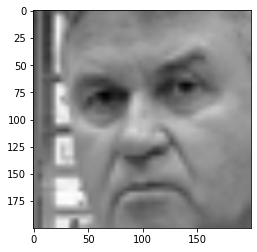

In [40]:
#Displaying the image shown by X_test[2]
image = np.reshape(pix.split(" "), (48,48)).astype("float")
image = cv2.resize(image, (200, 200)) # Reshaping images to preferred size
image -= np.mean(image)
image /= np.std(image)
#print(emotion_labels[training_data.at[index, "emotion"]])
plt.imshow(image, cmap="gray")

In [48]:
#How our model predicts this image
probablistic_preditions_vgg=vgg.predict(X_test)
output=np.round(probablistic_preditions_vgg[2],2)
u=output.argsort()[-2:][::-1]
print("The model has predicted",round(output[u[0]]*100,2),'% of',emotion_labels[u[0]],'and',round(output[u[1]]*100,2),'% of',emotion_labels[u[1]] )

The model has predicted 62.0 % of Angry and 17.0 % of Fear


In [49]:
#class prediction for test data
predictions_vgg = np.argmax(vgg.predict(X_test), axis=-1)
predictions_vgg[:15]

array([0, 1, 0, 4, 3, 3, 2, 4, 6, 4, 3, 0, 4, 2, 6])

In [50]:
#display classification report for each of the classes
print(classification_report(y_test.idxmax(axis = 1), predictions_vgg, target_names = emotion_labels))

              precision    recall  f1-score   support

       Angry       0.57      0.54      0.55       467
     Disgust       0.54      0.57      0.56        56
        Fear       0.53      0.45      0.49       496
       Happy       0.88      0.79      0.83       895
         Sad       0.54      0.55      0.55       653
    Surprise       0.77      0.80      0.78       415
     Neutral       0.54      0.68      0.60       607

    accuracy                           0.65      3589
   macro avg       0.62      0.63      0.62      3589
weighted avg       0.65      0.65      0.65      3589



[Text(69.0, 0.5, 'Predicted Outcome'), Text(0.5, 69.0, 'Actual Outcome')]

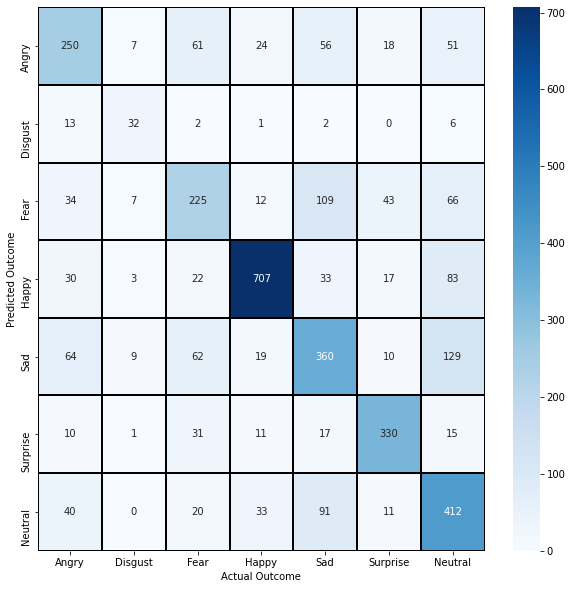

In [51]:
#to plot a confusion matrix
cm=confusion_matrix(y_test.idxmax(axis = 1), predictions_vgg)
cm1 = pd.DataFrame(cm , index = emotion_labels , columns = emotion_labels)
plt.figure(figsize = (10,10))
ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
ax.set(xlabel="Actual Outcome", ylabel = "Predicted Outcome")